In [224]:
import requests
import zipfile
import io
# downloading the dataset

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"
response = requests.get(url)
if response.status_code == 200:
    print("Successfully fetched the webpage.")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")
filename = "Attribute Information.docx"
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List all files in the zip
    print(z.namelist())
    # Extract the csv file
    z.extract("Absenteeism_at_work.csv", path=".")
    print("Extracted Absenteeism_at_work.csv")
    z.extract(filename, path=".")

import docx

doc = docx.Document(filename)
fullText = []
for para in doc.paragraphs:
    fullText.append(para.text)
text = '\n'.join(fullText)
# regex
import re
# filter out anything before \nI
texst = re.search(r'\nI.*?\(28\)', text, re.DOTALL).group(0)
texst = texst.split('\n')
texst = [i for i in texst if i != '']
texsst = [(' ').join(i.split(' ')[1:]).strip() for i in texst[:21]] + [i.split(' (')[0] for i in texst[21].split('CID) ')[1].split(', ')]
texsst = [i.capitalize().split('.')[0] for i in texsst]
absence_reasons = {}
for i in range(len(texsst)):
    absence_reasons[i] = texsst[i]


Successfully fetched the webpage.
['Absenteeism_at_work.arff', 'Absenteeism_at_work.csv', 'Absenteeism_at_work.xls', 'Attribute Information.docx', 'UCI_ABS_TEXT.docx']
Extracted Absenteeism_at_work.csv


In [225]:
import pandas as pd
df = pd.read_csv("Absenteeism_at_work.csv", sep=";")
#df['Reason for absence'] = df['Reason for absence'].map(absence_reasons)
# Investigating datapoint distribution for each employee (ID)
df['ID'].value_counts()
def visualize_data_distribution(df, column_name):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


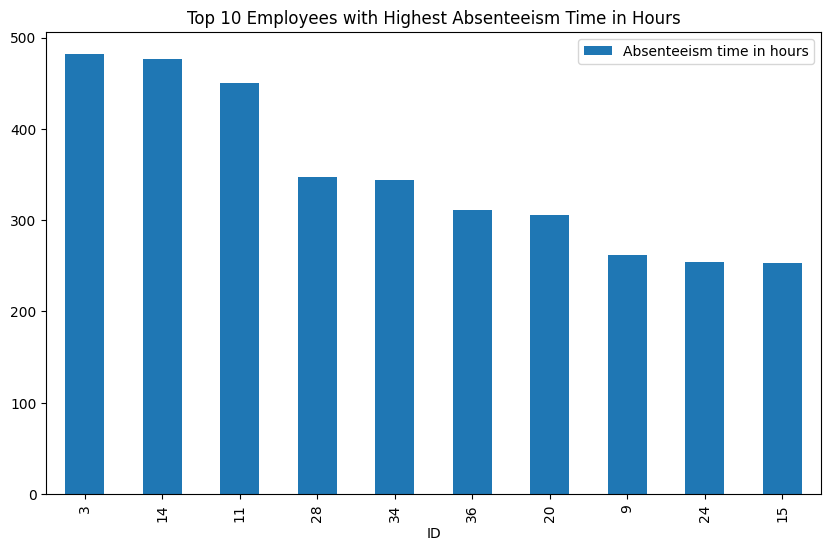

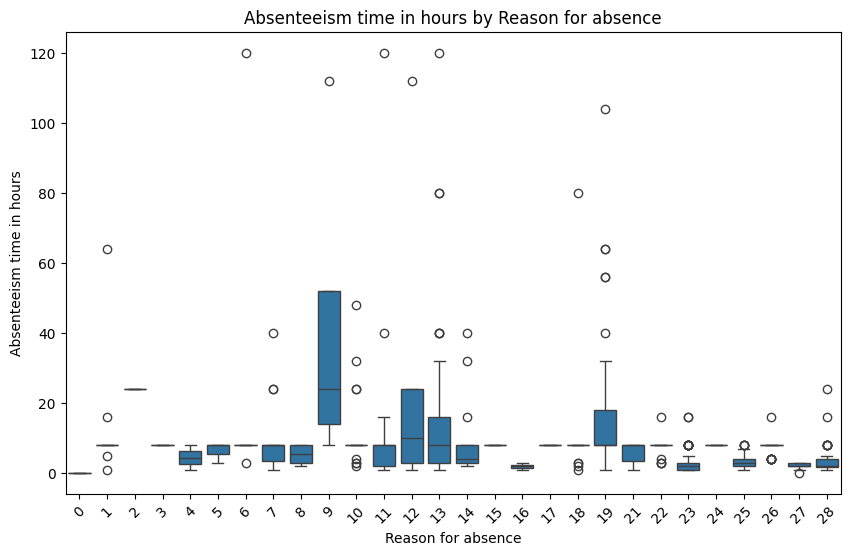

In [226]:
# find the mean, min, max, median, std of absenteeism in hours for each absence reason
def visualize_absenteeism_distribution(df, column_name):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=column_name, y='Absenteeism time in hours')
    plt.title(f'Absenteeism time in hours by {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Absenteeism time in hours')
    plt.xticks(rotation=45)
    plt.show()

# plot sum of absenteeism time in hours for each person
df.groupby('ID')['Absenteeism time in hours'].sum().reset_index().sort_values(by='Absenteeism time in hours', ascending=False).head(10).plot(x='ID', y='Absenteeism time in hours', kind='bar', figsize=(10, 6), title='Top 10 Employees with Highest Absenteeism Time in Hours')
visualize_absenteeism_distribution(df, 'Reason for absence')

In [227]:
print(df[df['Disciplinary failure'] == 1]['Reason for absence'].value_counts())
ids_reasonforabs = df[(df['Reason for absence'] == 0) & (df['Disciplinary failure'] == 0)]['ID'].to_list()
df.drop(df[(df['ID'].isin(ids_reasonforabs)) & (df['Disciplinary failure'] == 0)].index, inplace=True)
# found one incorrect data point for no absences (this person has a disciplinary failure)
# reason for absence 0 represents either a disciplinary failure (most likely getting fired) or no absences

Reason for absence
0    40
Name: count, dtype: int64


<Axes: title={'center': 'Work Load Average per Day for Employee ID 3'}, xlabel='Month of absence'>

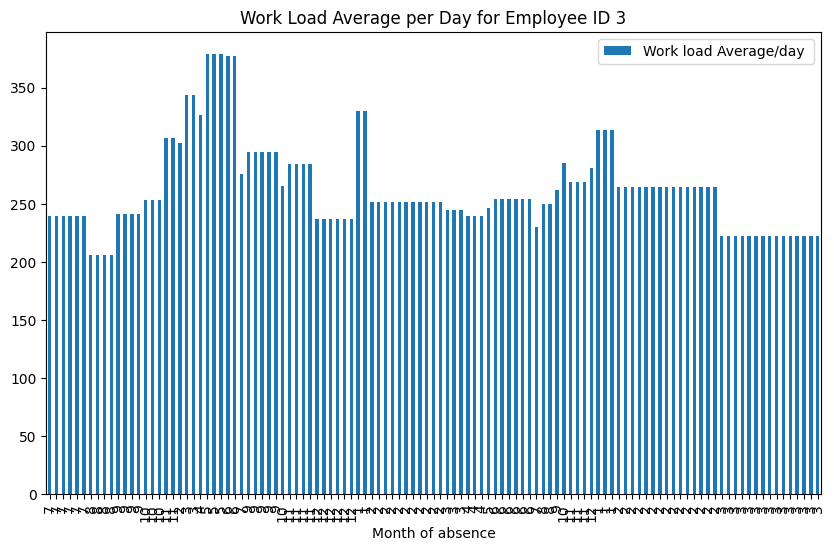

In [ ]:
# plot work load average over time
df[df['ID'] == 3].reset_index(drop=True).plot(x='Month of absence', y='Work load Average/day ', kind='bar', figsize=(10, 6), title='Work Load Average per Day for Employee ID 3')
# Workload is the average per day of a given month.

In [ ]:
# Finding the columns that have no std and are thus personal information
indi_columns = []
nonindi_columns = []
for i in df['ID'].unique():
    if df[df['ID'] == i].shape[0] > 10:
        df_individual = df[df['ID'] == i]
        print(f"Individual {i} has {df_individual.shape[0]} absences")
        break
for column in df_individual.columns:
    # print the std of the column
    if df_individual[column].std() == 0:
        print(f"Column {column} has no std")
        indi_columns.append(column)
    else:
        print(f"Column {column} has std {df_individual[column].std()}")
        nonindi_columns.append(column)
    
# create a new dataframe with only the individual columns
indi_df = df[indi_columns]

# drop duplicate ids, keep the first one
indi_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
indi_df.set_index("ID", inplace=True)
indi_df.sort_index(inplace=True)

# make a columns for whether a person has had a disciplinary failure or not
discp_per_id = df.groupby('ID')['Disciplinary failure'].sum()
discp_per_id = discp_per_id.map(lambda x: 1 if x > 0 else 0)
indi_df['Disciplinary failure'] = discp_per_id

# make a columns for the total absenteeism time in hours
indi_df['Total Absenteeism Time'] = df.groupby('ID')['Absenteeism time in hours'].sum()

Individual 11 has 40 absences
Column ID has no std
Column Reason for absence has std 6.621642835894567
Column Month of absence has std 3.2486683662458
Column Day of the week has std 1.320207831346534
Column Seasons has std 1.2025613689761725
Column Transportation expense has no std
Column Distance from Residence to Work has no std
Column Service time has no std
Column Age has no std
Column Work load Average/day  has std 43.88726102079843
Column Hit target has std 3.7997975654581313
Column Disciplinary failure has std 0.22072142786315221
Column Education has no std
Column Son has no std
Column Social drinker has no std
Column Social smoker has no std
Column Pet has no std
Column Weight has no std
Column Height has no std
Column Body mass index has no std
Column Absenteeism time in hours has std 16.4935884979122


C:\Users\Tijn\AppData\Local\Temp\ipykernel_13840\2200147647.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indi_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_13840\2200147647.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indi_df.sort_index(inplace=True)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_13840\2200147647.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
df['ID'].unique().tolist().sort


In [285]:
# make a column for the amount of absence time that is unjustified absence (26 in category of absence)
unjust_dict  = df[df['Reason for absence'] == 26].groupby('ID')['Absenteeism time in hours'].sum().to_dict()
unjust_dict


{1: 12,
 3: 8,
 5: 68,
 11: 44,
 13: 16,
 18: 12,
 20: 36,
 24: 16,
 33: 4,
 34: 20,
 36: 4}

In [ ]:
for i in df['ID'].unique():
    if i not in unjust_dict.keys():
        unjust_dict[int(i)] = 0
# sort the keys in the dictionary by numeric value
unjust_dict = dict(sorted(unjust_dict.items()))
unjust_dict